# Springboard Time Series - 'Cowboy Cigarettes' Case Study

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  


## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [4]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [7]:
cigData.head()


,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


In [8]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [9]:
len(cigData.columns)


3

Let's check out the data types of our columns.

In [10]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [12]:
cigData.isnull().values.any()

np.False_

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [13]:
cigData = cigData.drop(columns=['Unnamed: 0'])


In [14]:
cigData.columns

Index(['Time', '#CigSales'], dtype='object')

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [15]:
cigData = cigData.rename(columns={'Time': 'Month'})


Call a head() to check this has worked. 

In [16]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [17]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.set_index('Month', inplace = True)

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [19]:
cigData

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121
...,...
1960-08-01,1000606
1960-09-01,1000508
1960-10-01,1000461


In [20]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [21]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [22]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

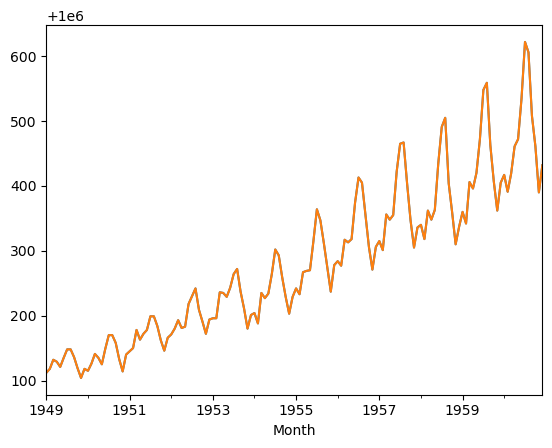

In [24]:
y.plot()
plt.show()

## 3. Modelling

### 3a. Decomposition

#### Observations from the Time Series Plot

From examining the plot of monthly cigarette sales at Cowboy Cigarettes, several key patterns are evident:

- There is a **strong upward trend** over time, indicating that cigarette sales have been increasing overall.
- The data shows **clear and regular seasonal fluctuations**, with peaks and troughs repeating in a consistent pattern.
- The **magnitude of the seasonal fluctuations increases over time**. Early in the series, the peaks and troughs are relatively small, while later they become much larger.
- The **variance of the series grows with its level**, meaning the fluctuations become more pronounced as sales increase.
- Peaks appear sharper and more pronounced than troughs, especially in later years.

#### Timing of Seasonal Fluctuations

The seasonal pattern appears to be **annual**, repeating approximately every 12 months. This suggests that the data has **monthly granularity with yearly seasonality**. Peaks and troughs tend to occur in the same months each year, indicating a stable seasonal cycle.

#### Hypotheses for the Cause of Seasonality

Possible explanations for these recurring seasonal patterns include:

- **Seasonal consumer behavior**, such as increased social activity during certain times of the year.
- **Weather-related effects**, where cigarette consumption varies by season.
- **Tourism or population changes** that follow an annual cycle.
- **Business or promotional cycles**, including annual pricing or distribution patterns.
- **Regulatory or tax timing**, which may encourage stockpiling before known policy changes.

#### Additive vs. Multiplicative Model

Based on the visual inspection of the plot, the data is best described by a **multiplicative model**:

- The overall trend is not increasing at a constant rate; instead, the rate of increase itself grows over time.
- Seasonal fluctuations become larger as the level of the series increases.

In contrast, an additive model would imply constant seasonal effects and a linear trend, which is not consistent with the observed behavior in the data.

Therefore, a **multiplicative decomposition** is more appropriate for modeling the Cowboy Cigarettes time series.


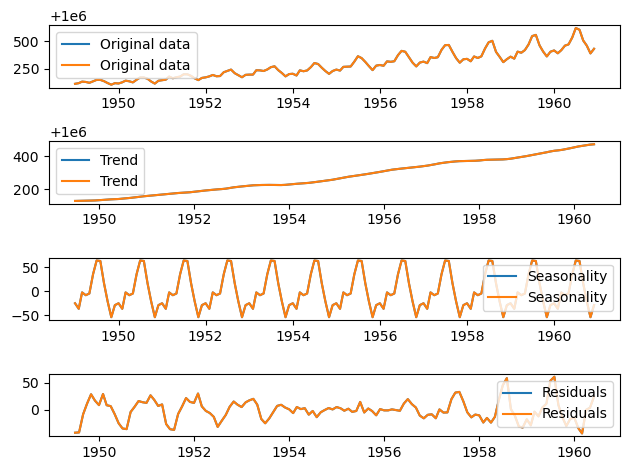

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y, label = 'Original data')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')

plt.tight_layout()

plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [28]:
from statsmodels.tsa.stattools import kpss

# Use kpss()
kpss(y)

/var/folders/pp/_9g9bqld5wb47ph0cdnwm7_r0000gn/T/ipykernel_42710/261422229.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(y)


(np.float64(1.6513122354170822),
 np.float64(0.01),
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

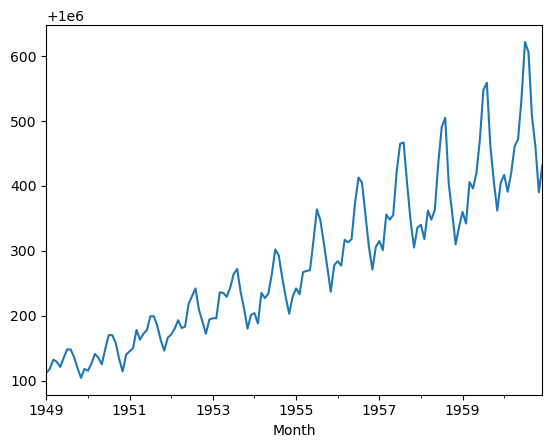

In [29]:
y.plot()

plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [30]:
y_log = np.log(y)


When you plot this, you can see how the variance in our data now remains contant over time.

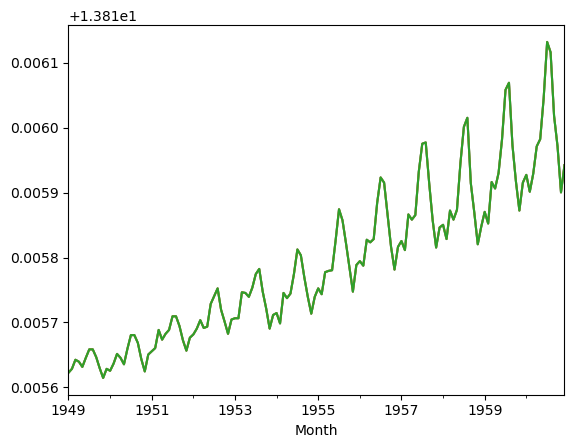

In [33]:
y_log.plot()

plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [34]:
kpss(y_log.diff().dropna())

/var/folders/pp/_9g9bqld5wb47ph0cdnwm7_r0000gn/T/ipykernel_42710/1327700776.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(y_log.diff().dropna())


(np.float64(0.023897674207570566),
 np.float64(0.1),
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [35]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model

In [54]:
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

def evaluate_arima_model(data, arima_order):
    data = data.dropna()
    split = int(len(data) * 0.8)

    train = data.iloc[:split]
    test  = data.iloc[split:]

    history = train.tolist()
    predictions = []

    for i in range(len(test)):
        model = ARIMA(history, order=arima_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)
        history.append(test.iloc[i])

    return mean_squared_error(test, predictions)



#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [55]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.dropna()
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    print(f"ARIMA{order} MSE={mse:.3f}")
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except Exception as e:
                    print(f"ARIMA{order} failed: {type(e).__name__}: {e}")

    print(f"Best ARIMA{best_cfg} MSE={best_score:.3f}")
    return best_cfg, best_score



In [56]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [57]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 0, 2) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 1, 2) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(1, 2, 1) MSE=0.000
ARIMA(1, 2, 2) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 0, 2) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 1) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA(2, 1, 1) MSE=0.000


((2, 1, 1), 2.312714516655685e-09)

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [58]:
p=2
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [59]:
# Call summary() on model_fit
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1287.245
Date:                Tue, 16 Dec 2025   AIC                          -2566.490
Time:                        10:58:03   BIC                          -2554.639
Sample:                    01-01-1949   HQIC                         -2561.674
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575   1.33e-19   7.98e+18      0.000       1.057       1.057
ar.L2         -0.4391   7.17e-19  -6.12e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.89e-20  -1.82e+19      0.000      -0.708      -0.708
sigma2      7.158e-10   2.65e-10      2.705      0.007    1.97e-10    1.23e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.40   Prob(JB):                         0.73
Heteroskedasticity (H):               7.95   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+35. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

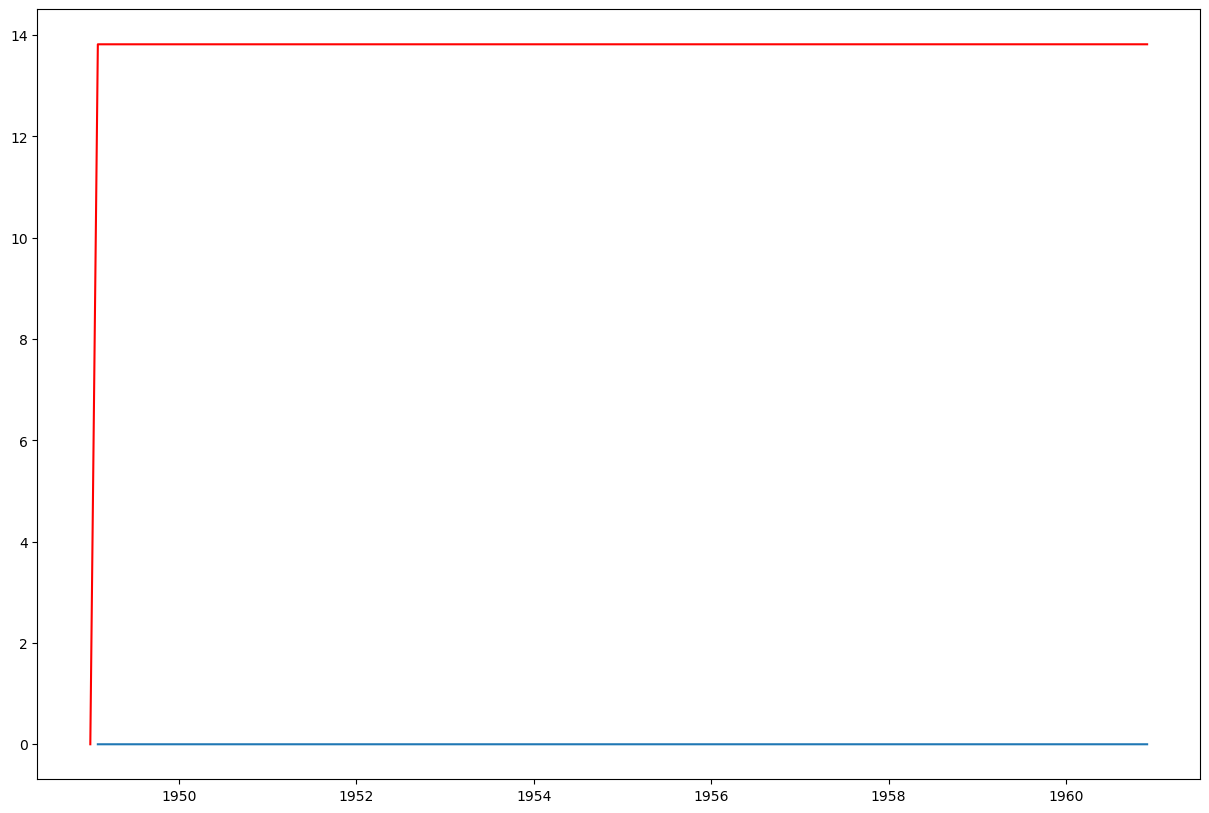

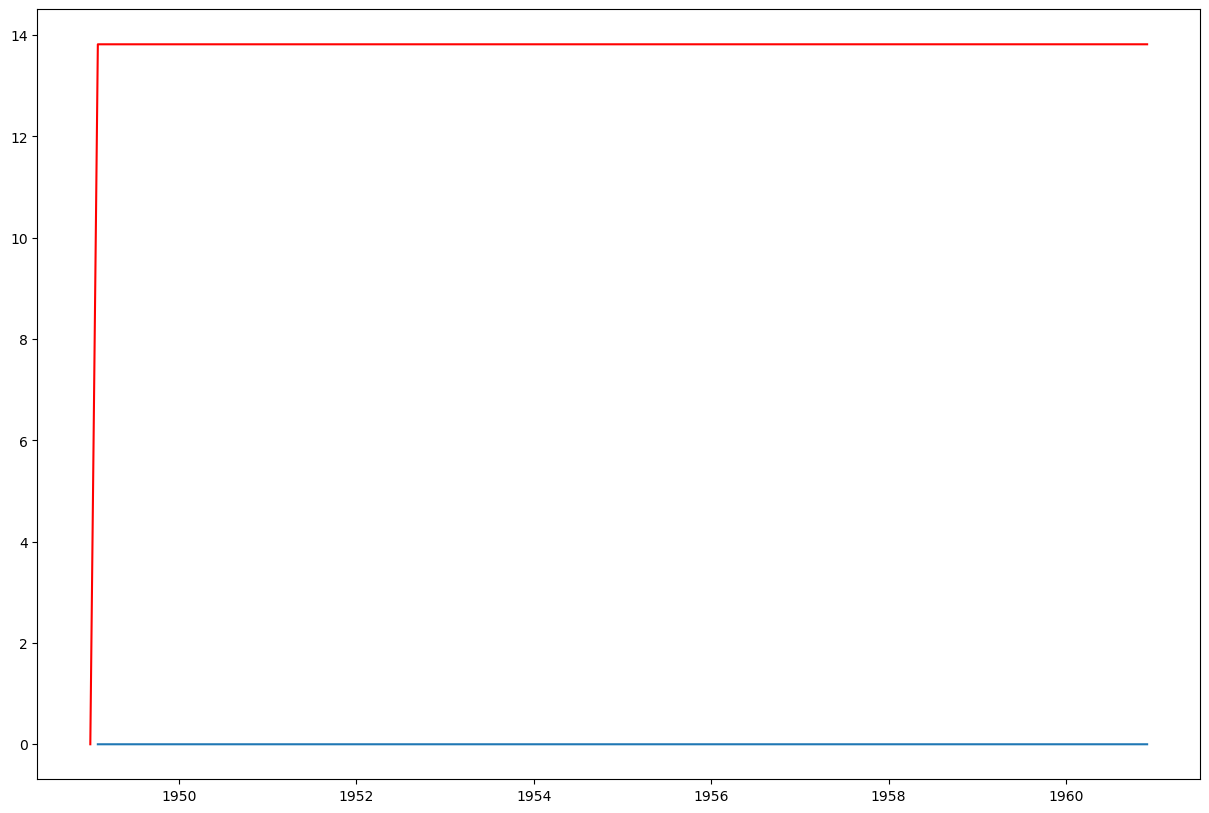

In [65]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color='red')

plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

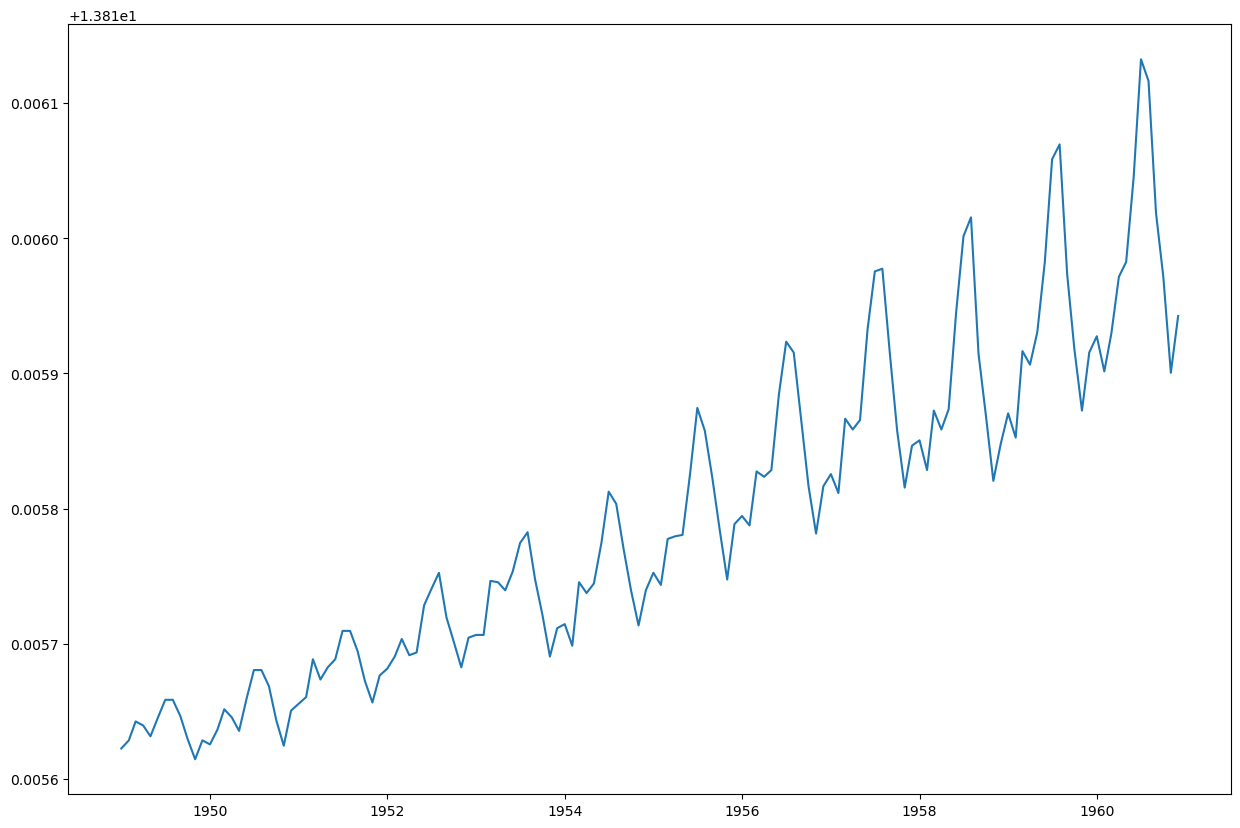

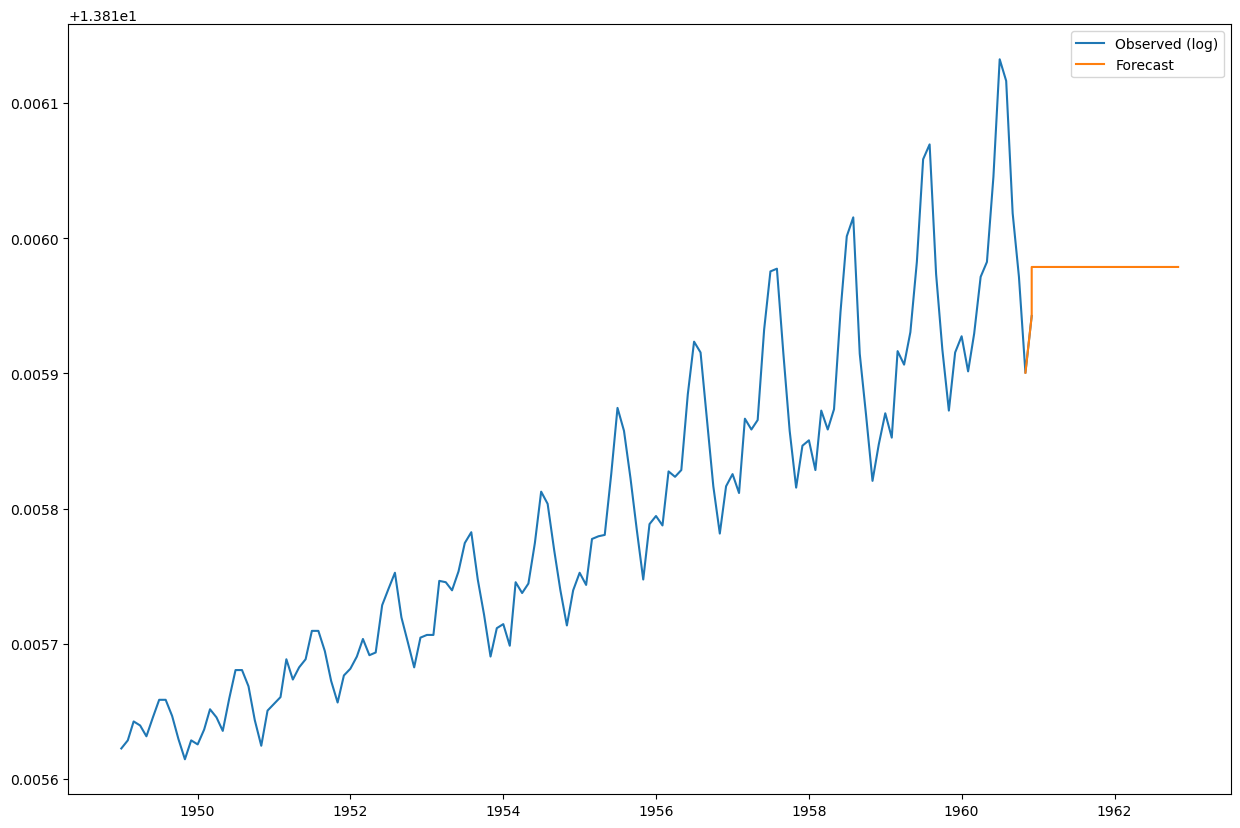

In [67]:

forecast_period = 24

date_range = pd.date_range(y_log.index[-1], periods=forecast_period, 
                           freq='MS').strftime("%Y-%m-%d").tolist()


future_months = pd.DataFrame(date_range, columns=['Month'])

future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace=True)

future_months['Prediction'] = forecast[0]


plt.figure(figsize=(15,10))
plt.plot(y_log, label='Observed (log)')
plt.plot(
    pd.concat([y_log.loc['1960-11':], future_months['Prediction']]),
    label='Forecast'
)
plt.legend()
plt.show()

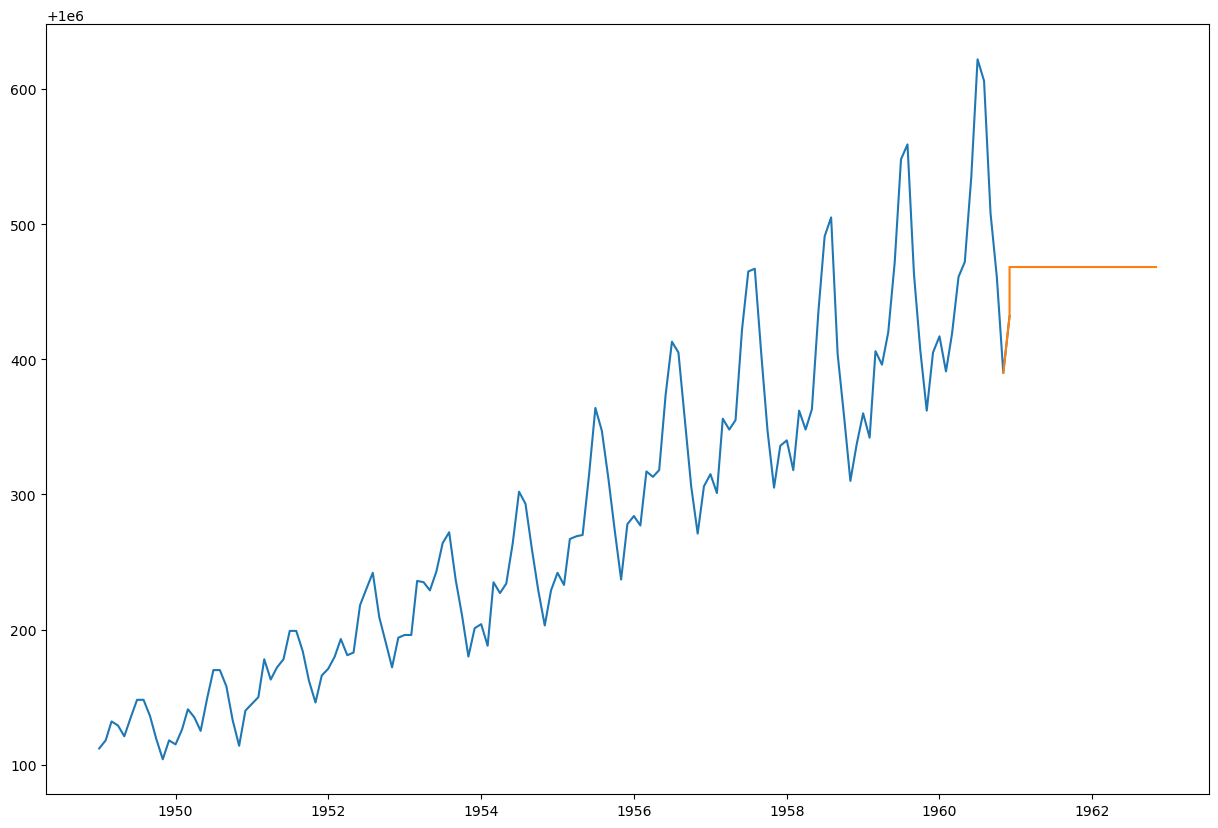

In [68]:
# Now plot the original variable y 
# Use the same functions as before
plt.figure(figsize=(15,10))
plt.plot(y)
plt.plot(
    np.exp(
        pd.concat([y_log.loc['1960-11':], future_months['Prediction']])
    )
)
plt.show()


## 4. Evaluating and Concluding

Our model captures the central trajectory of cigarette sales, which shows a strong and rapidly increasing upward trend over time. Cowboy Cigarettes consistently sell more cigarettes during the summer months, possibly due to better weather, increased disposable income, and more leisure time. In contrast, sales tend to be lowest during the winter, when spending may decrease and outdoor social activity is reduced.

Notably, the ARIMA model generates these predictions using only a single variable—the historical sales data itself. As a result, while the model is effective at identifying trends and seasonality, it does not explain the underlying causes driving these patterns. Any interpretation of the reasons behind the observed behavior therefore remains speculative.

It is also important to recognize the limitations of ARIMA models. Sudden structural breaks or external shocks—such as wars, policy changes, or major economic disruptions are not handled well. For example, the outbreak of the Vietnam War in the 1960s could plausibly affect cigarette consumption patterns in ways that this model cannot anticipate or accommodate.

To better understand the drivers behind cigarette sales, we could recommend that Cowboy Cigarettes complement this time-series analysis with a regression-based approach. Incorporating external variables such as economic indicators, demographic trends, pricing, or policy changes would allow for a more explanatory model and provide deeper insight into the factors influencing sales behavior.
